In [18]:
import glob
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import product
import json
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [19]:
N_REPETITIONS = 10
N_ITERATIONS = 25
FPS_VALUES = [10, 12, 14, 15, 17, 20]
rs_ver = "rs_v2"
base_path = f"data/ronin/{rs_ver}"

In [20]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop(['records', 'index'], axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['fps', 'highquality', 'rep', 'it', 'route_id'])
    return df

In [21]:

def make_df(path: str):

    # DATA FROM PATH
    data = {}
    data['path'] = path
    stem = Path(path).stem.split("_")
    data['fps'] = int(stem[1])
    data['highquality'] = stem[3]
    match path.split("/"):
        case ["data", "ronin", rs_ver, rep, "checkpoints", it, *objects]:
            data['rep'] = int(rep)
            data['it'] = int(it[2:])
    # print(data)

    # READ CHECKPOINT
    with open(path, "r") as f:
        content = json.load(f)

        data['records'] = content['_checkpoint']['records']
        if not data['records']:
            return

        df = pd.DataFrame(data)
        return process_df(df)


dfs = []
pattern = f"{base_path}/*/checkpoints/it*/*.json"
for file in glob.glob(pattern):
    dfs.append(make_df(file))

In [22]:
df = pd.concat(dfs).sort_index()[['driving_score', 'duration_system']]
df = df.xs("True", level='highquality', drop_level=False)
# df.to_csv("df.csv")
df.reset_index().value_counts('route_id')

route_id
RouteScenario_625    8
RouteScenario_494    8
RouteScenario_655    7
RouteScenario_259    7
RouteScenario_104    7
                    ..
RouteScenario_637    1
RouteScenario_64     1
RouteScenario_192    1
RouteScenario_190    1
RouteScenario_656    1
Name: count, Length: 686, dtype: int64

In [23]:
def do_boxplot(df, column, ax=None):
    agg = df.groupby(["fps", "rep"])[column].mean()
    # use index as possition for correct spacing
    pos = agg.reset_index().groupby('fps')[column].mean().index
    agg.reset_index().boxplot(by='fps', column=column, ax=ax,
                              grid=True, positions=pos, widths=0.8)

## SOLUTIONS

In [24]:
# Get an index of minimal driving score for each fidelity value for each repetition
solutions_idx = df.groupby(
    ['fps', 'highquality', 'rep'],)['driving_score'].idxmin()
solutions = df.loc[solutions_idx][['driving_score', 'duration_system']]
solutions

driving_score  duration_system
fps highquality rep it route_id                                         
10  True        0   17 RouteScenario_311       0.075450       494.331251
                1   3  RouteScenario_337       0.059218       714.505364
                2   14 RouteScenario_278       0.054614      1497.857111
                3   17 RouteScenario_97        0.045128       412.859133
                4   15 RouteScenario_276       0.028958       483.226898
                5   20 RouteScenario_286       0.043634       492.360416
                6   21 RouteScenario_105       0.054533       503.102671
                7   7  RouteScenario_233       0.019790       625.858572
                8   10 RouteScenario_263       0.050729       722.696556
                9   18 RouteScenario_419       0.014509       479.442012
12  True        0   14 RouteScenario_59        0.033340       382.800361
                1   5  RouteScenario_595       0.070324       411.403101
                2   16 RouteScenario_99        0.031486       392.530027
                3   1  RouteScenario_337       0.044889       484.269693
                4   22 RouteScenario_53        0.044712       607.859215
                5   8  RouteScenario_337       0.041989       482.935943
                6   10 RouteScenario_107       0.030328       441.165970
                7   2  RouteScenario_263       0.052303       723.949086
                8   1  RouteScenario_602       0.113661       716.999831
                9   1  RouteScenario_69        0.099754       523.423729
14  True        0   8  RouteScenario_141       0.037605      3069.932215
                1   6  RouteScenario_342       0.033464       995.907285
                2   21 RouteScenario_248       0.008072       511.546673
                3   18 RouteScenario_392       0.004505       504.128639
                4   23 RouteScenario_248       0.008072       499.955741
                5   17 RouteScenario_395       0.066556       487.387737
                6   12 RouteScenario_77        0.183056       624.072903
                7   14 RouteScenario_160       0.047564       515.268482
                8   1  RouteScenario_263       0.050729       837.095898
                9   15 RouteScenario_574       0.055978       503.458481
15  True        0   20 RouteScenario_342       0.036013      1084.914932
                1   0  RouteScenario_408       0.169779      1000.179747
                2   18 RouteScenario_273       0.059833       974.183122
                3   24 RouteScenario_488       0.116338      3959.351618
                4   4  RouteScenario_338       0.154492      1072.434280
                5   13 RouteScenario_310       0.066807       951.577569
                6   15 RouteScenario_294       0.199386      1177.891253
                7   3  RouteScenario_245       0.039955      1937.514754
                8   2  RouteScenario_245       0.066194      1507.751883
                9   11 RouteScenario_337       0.125189      1089.106612
17  True        0   0  RouteScenario_155       0.117861      2443.535655
                1   3  RouteScenario_247       0.025977       872.051950
                2   14 RouteScenario_214       0.089366       629.804895
                3   4  RouteScenario_245       0.110324      1161.978930
                4   16 RouteScenario_140       0.065672      6174.141449
                5   17 RouteScenario_159       0.143719       683.299481
                6   17 RouteScenario_140       0.303804      5721.995005
                7   10 RouteScenario_231       0.127177      1092.712209
                8   17 RouteScenario_248       0.007640       645.206162
                9   22 RouteScenario_136       0.209695      2153.489664
18  True        0   13 RouteScenario_392       0.004505       635.618093
                1   2  RouteScenario_160       0.047564       641.234964
                2   2  RouteScenario_595       0.070324       585.220800
                3   17 Rout

## VERIFICATION

In [25]:
def process_verification_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop(['records', 'index'], axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['route_id'])
    return df


def make_verification_df(path: str):

    # DATA FROM PATH
    data = {}
    data['path'] = path

    # READ CHECKPOINT
    with open(path, "r") as f:
        content = json.load(f)

        data['records'] = content['_checkpoint']['records']
        if not data['records']:
            return

        df = pd.DataFrame(data)
        return process_verification_df(df)

In [26]:
dfs = []
pattern = f"{base_path}/verification/checkpoints/*/*.json"
for file in glob.glob(pattern):
    # print(file)
    dfs.append(make_verification_df(file))

oracle_df = pd.concat(dfs).sort_index()[['driving_score']]

# deduplicate
oracle_df = oracle_df.groupby(oracle_df.index).last()
oracle_df = oracle_df.rename(columns={"driving_score": "oracle_dscore"})
# oracle_df

In [27]:
joined = solutions.join(oracle_df)


joined['rmse'] = (joined['oracle_dscore'] -
                  joined['driving_score']).pow(2.0).pow(0.5)

joined

driving_score  duration_system  oracle_dscore      rmse
fps highquality rep it route_id                                                                  
10  True        0   17 RouteScenario_311       0.075450       494.331251       0.074260  0.001190
                1   3  RouteScenario_337       0.059218       714.505364       0.600000  0.540782
                2   14 RouteScenario_278       0.054614      1497.857111       1.000000  0.945386
                3   17 RouteScenario_97        0.045128       412.859133       1.000000  0.954872
                4   15 RouteScenario_276       0.028958       483.226898       0.027757  0.001201
                5   20 RouteScenario_286       0.043634       492.360416       1.000000  0.956366
                6   21 RouteScenario_105       0.054533       503.102671       1.000000  0.945467
                7   7  RouteScenario_233       0.019790       625.858572       1.000000  0.980210
                8   10 RouteScenario_263       0.050729       722.696556       0.045512  0.005217
                9   18 RouteScenario_419       0.014509       479.442012       1.000000  0.985491
12  True        0   14 RouteScenario_59        0.033340       382.800361       1.000000  0.966660
                1   5  RouteScenario_595       0.070324       411.403101       0.070324  0.000000
                2   16 RouteScenario_99        0.031486       392.530027       0.700000  0.668514
                3   1  RouteScenario_337       0.044889       484.269693       0.600000  0.555111
                4   22 RouteScenario_53        0.044712       607.859215       1.000000  0.955288
                5   8  RouteScenario_337       0.041989       482.935943       0.600000  0.558011
                6   10 RouteScenario_107       0.030328       441.165970       0.700000  0.669672
                7   2  RouteScenario_263       0.052303       723.949086       0.045512  0.006791
                8   1  RouteScenario_602       0.113661       716.999831       1.000000  0.886339
                9   1  RouteScenario_69        0.099754       523.423729       1.000000  0.900246
14  True        0   8  RouteScenario_141       0.037605      3069.932215       0.289698  0.252093
                1   6  RouteScenario_342       0.033464       995.907285       1.000000  0.966536
                2   21 RouteScenario_248       0.008072       511.546673       0.007640  0.000432
                3   18 RouteScenario_392       0.004505       504.128639       0.004505  0.000000
                4   23 RouteScenario_248       0.008072       499.955741       0.007640  0.000432
                5   17 RouteScenario_395       0.066556       487.387737       0.066556  0.000000
                6   12 RouteScenario_77        0.183056       624.072903       0.700000  0.516944
                7   14 RouteScenario_160       0.047564       515.268482       0.046386  0.001178
                8   1  RouteScenario_263       0.050729       837.095898       0.045512  0.005217
                9   15 RouteScenario_574       0.055978       503.458481       0.055978  0.000000
15  True        0   20 RouteScenario_342       0.036013      1084.914932       1.000000  0.963987
                1   0  RouteScenario_408       0.169779      1000.179747       0.158114  0.011664
                2   18 RouteScenario_273       0.059833       974.183122       0.058740  0.001094
                3   24 RouteScenario_488       0.116338      3959.351618       0.537831  0.421493
                4   4  RouteScenario_338       0.154492      1072.434280       1.000000  0.845508
                5   13 RouteScenario_310       0.066807       951.577569       0.059617  0.007190
                6   15 RouteScenario_294       0.199386      1177.891253       0.508761  0.309375
                7   3  RouteScenario_245       0.039955      1937.514754       0.169976  0.130020
                8   2  RouteScenario_245       0.066194      1507.751883       0.169976  0.103782
                9   11 R

## FIGURES

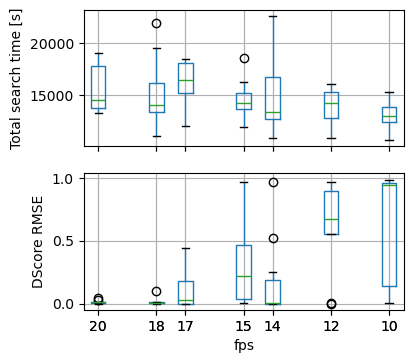

In [28]:
fig, ax = plt.subplots(nrows=2, squeeze=True, sharex=True)
fig.set_size_inches(4, 4)

# BOX PLOT FOR TOTAL TIME
total_time = df.groupby(
    ['fps', 'rep', ])['duration_system'].sum()

pos = total_time.reset_index().groupby('fps')['duration_system'].mean().index

total_time.reset_index().boxplot(by='fps', positions=pos,
                                 column='duration_system', ax=ax[0])


ax[0].set_ylabel(f"Total search time [s]")
ax[0].set_title("")
ax[0].set_xlabel("")

ax[0].invert_xaxis()

# BOX PLOT FOR RMSE

rmse = joined.groupby(['fps', 'rep', ])['rmse'].mean()

rmse.reset_index().boxplot(by='fps', positions=pos,
                           column='rmse', ax=ax[1])

ax[1].set_ylabel(f"DScore RMSE")
ax[1].set_title("")
fig.suptitle('')

fig.savefig('rs_boxplot.pdf', bbox_inches='tight')

## Number of unique scenarios

In [29]:
joined = joined.reset_index()
# getting rid of "RouteScenario_"
joined['route_id'] = joined['route_id'].apply(
    lambda x: x.split("_")[-1]).apply(int)

/home/olek/anaconda3/envs/data-science/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='fps', ylabel='Count'>

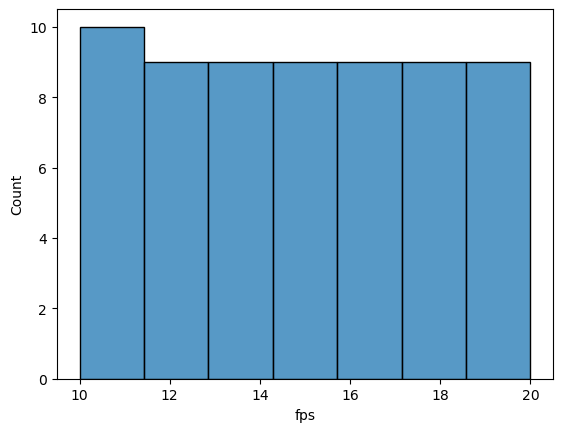

In [30]:


sns.histplot(joined.drop_duplicates(['fps', 'route_id']), x='fps')

In [31]:
id_and_fps = joined.sort_values('route_id')[['route_id', 'fps', 'it', 'rep']]
id_and_fps.set_index(['fps', 'it', 'rep'])

route_id
fps it rep          
12  22 4          53
    14 0          59
    1  9          69
14  12 6          77
10  17 3          97
12  16 2          99
10  21 6         105
12  10 6         107
17  22 9         136
    16 4         140
    17 6         140
14  8  0         141
17  0  0         155
18  23 6         159
17  17 5         159
18  2  1         160
14  14 7         160
18  18 4         160
17  14 2         214
    10 7         231
10  7  7         233
17  4  3         245
15  2  8         245
    3  7         245
17  3  1         247
    17 8         248
14  21 2         248
    23 4         248
18  23 5         258
20  21 8         261
12  2  7         263
14  1  8         263
10  10 8         263
20  1  7         271
18  9  8         271
15  18 2         273
10  15 4         276
    14 2         278
    20 5         286
15  15 6         294
20  13 2         297
15  13 5         310
20  8  3         310
10  17 0         311
12  1  3         337
10  3  1         337
12  8  5         337
15  11 9         337
    4  4         338
    20 0         342
14  6  1         342
20  13 4         388
    8  1         388
    18 5         391
18  13 0         392
14  18 3         392
    17 5         395
18  5  9         407
15  0  1         408
18  21 7         408
10  18 9         419
15  24 3         488
20  0  6         507
18  17 3         572
14  15 9         574
20  18 0         589
12  5  1         595
18  2  2         595
12  1  8         602
20  0  9         730

/home/olek/anaconda3/envs/data-science/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='route_id', ylabel='Count'>

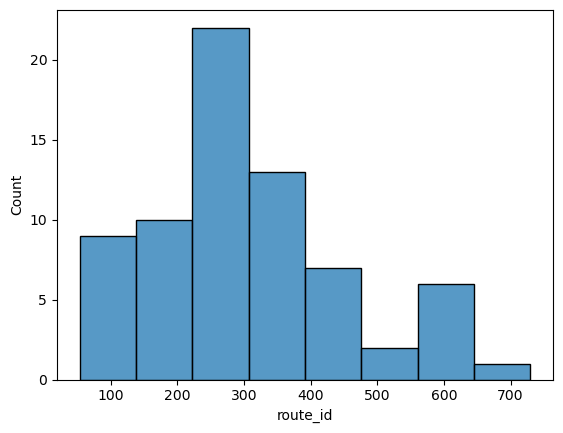

In [32]:
sns.histplot(id_and_fps, x='route_id',)

/home/olek/anaconda3/envs/data-science/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='route_id', ylabel='Count'>

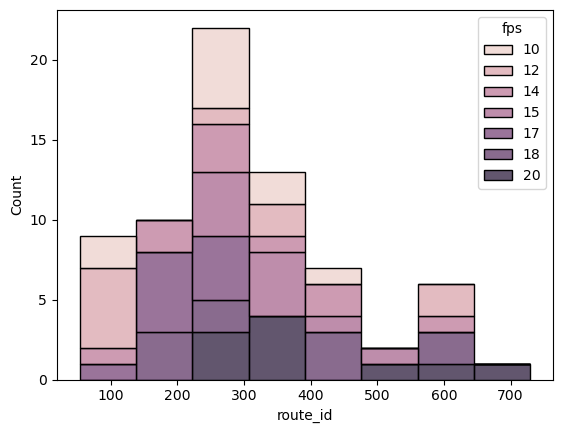

In [33]:
# sns.scatterplot(x=id_and_fps['route_id'], y=id_and_fps['fps'])
# id_and_fps.hist()

sns.histplot(id_and_fps, x='route_id', hue='fps', multiple='stack')

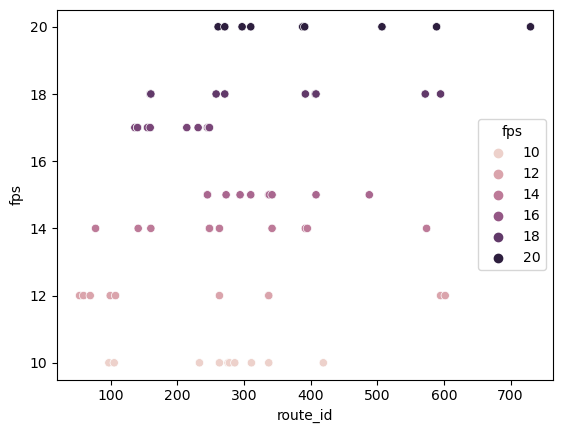

In [41]:
ax = sns.scatterplot(id_and_fps, y='fps', x='route_id', hue='fps',)
sns.move_legend(ax, "center right")

## Similarity of diffrent scenarios

## Load V2

In [ ]:
base_path = f"data/ronin/rs_v2"
dfs = []
pattern = f"{base_path}/*/checkpoints/it*/*.json"
for file in glob.glob(pattern):
    dfs.append(make_df(file))

df = pd.concat(dfs).sort_index()[['driving_score', 'duration_system']]
df = df.join(oracle_df).sort_index()

In [ ]:

cm = get_cumulative_min(df)
time_sum = get_time_sum(df)

In [ ]:
data = pd.concat([cm, time_sum], axis=1,)
data = data.groupby(['fps', 'highquality', 'it']).mean()
# data

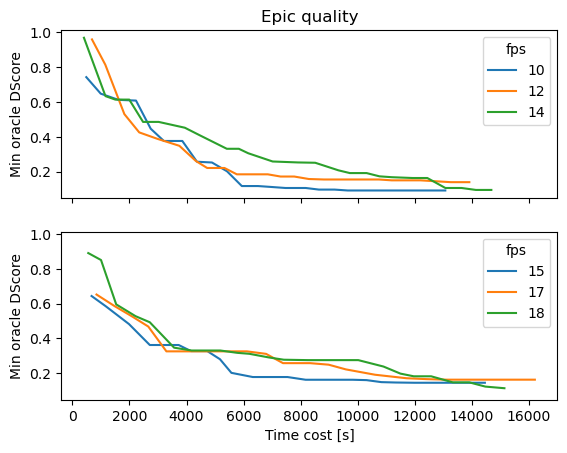

In [ ]:
def plot_more_fid(data, x='it'):
    f, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
    sns.lineplot(x=x, y="min_oracle_dscore",
                 hue="fps",
                 data=data.loc[["10", "12", "14",]].reset_index(), ax=ax[0], errorbar=None)

    sns.lineplot(x=x, y="min_oracle_dscore",
                 hue="fps",
                 data=data.loc[["15", "17", "18"]].reset_index(), ax=ax[1], errorbar=None)

    ax[0].set_title("Epic quality")

    ax[0].set_ylabel(f"Min oracle DScore")
    ax[1].set_ylabel(f"Min oracle DScore")

    if x == 'it':
        ax[1].set_xlabel(f"Iteration number")
    elif x == 'time_sum':
        ax[1].set_xlabel(f"Time cost [s]")


plot_more_fid(data, x='time_sum')